First & Second Name:`MohammadParsa Dini`

Student ID: `400101204`

Note I: Each section is worth 50 points. Each question is worth 5 points, and your implementation is worth 30 points in total. (5 × 4 + 30 = 50) × 2 = 100.

Note II: For each section, your model (agent) can converge. By achieving convergence in each section, you will earn an additional **5 points** per section. Alternatively, if your agent demonstrates an incremental average return, that will suffice.

# Section One

### Develop the model of nueral network for training agent.

In this section, you’ll embark on implementing a Deep Q-Network (DQN) agent from scratch, one of the fundamental algorithms in deep reinforcement learning. DQN revolutionized the field by successfully combining deep neural networks with Q-learning, enabling agents to learn directly from high-dimensional sensory inputs. You’ll build each component systematically - starting with the neural network architecture that approximates Q-values, then implementing the experience replay buffer that breaks correlations in training data, followed by the epsilon-greedy policy for balancing exploration and exploitation, and finally bringing it all together in the DQN agent class. This hands-on implementation will deepen your understanding of how value-based reinforcement learning algorithms work under the hood.
Below is the schema for DQN implementation

![image-3](https://www.researchgate.net/publication/344238597/figure/fig4/AS:935663859937283@1600091056689/DQN-training-process.png)

The CartPole-v1 environment serves as your testing ground - a classic control problem where an agent must balance a pole on a moving cart. Through this implementation, you’ll gain practical experience with key concepts like target networks for stable learning, batch sampling from replay memory, and the temporal difference learning update rule. Pay special attention to how each component interacts with others: how the neural network processes states to output Q-values, how the replay buffer stores and samples experiences, and how the epsilon-greedy policy uses these Q-values to select actions. The visualization at the end will show your agent’s learning progress across multiple random seeds, demonstrating the effectiveness of your implementation. The conceptual questions following the implementation will help solidify your understanding of where DQN fits in the broader landscape of reinforcement learning algorithms.

# Implement Models

In [1]:
!pip install gymnasium 


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.optim as optim
import torch
import collections
import random
from collections import namedtuple
import numpy as np
import tqdm
import collections

Transition = collections.namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class FCModel(nn.Module):
    """ Implement a dense nn for using on QNetwork"""

    def __init__(self, input_size, output_size):
        #####################################################################
        # TODO:
        # 1) Creat a nueral network (dense) for getting with input_size and return output_size
        super(FCModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )
        #####################################################################

    def forward(self, inputs):
        #####################################################################
        # TODO:
        # 2) Implement forward function

        return self.model(inputs)
        #####################################################################
    #pass

# QNetwork class
class QNetwork:
    """ Implement QNetwork for estimate q-values"""
    def __init__(self, env, lr):

        #####################################################################
        # TODO:
        # 3) Implement optimizer
        # 4) Implement suitable lr
        # 5) and self.net which contain a FCModel in it

        input_dim = env.observation_space.shape[0]   # CartPole: 4
        output_dim = env.action_space.n              # CartPole: 2
        self.net = FCModel(input_dim, output_dim)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        #####################################################################

### Develop the replay buffer for adding experiences in buffers.

In [3]:
# Memory/Replay Buffer class
class ReplayMemory:
    def __init__(self, env, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.memory = collections.deque(maxlen=memory_size)
        self.env = env
    
    def __len__(self):
        return len(self.memory)
    
    def sample_batch(self, batch_size=32):
        #####################################################################
        # TODO:
        # 6) Impelement sample batch function to return sample from replay buffer with giben batch size 

        return random.sample(self.memory, batch_size)
        #####################################################################


    # def append(self, transition):
    #     self.memory.append(transition)
    def append(self, transition):
        # Convert all elements to tensors before storing
        state = torch.tensor(transition.state, dtype=torch.float32).unsqueeze(0) if isinstance(transition.state, np.ndarray) else transition.state
        action = torch.tensor([[transition.action]], dtype=torch.long) if isinstance(transition.action, (int, np.int64)) else transition.action
        next_state = torch.tensor(transition.next_state, dtype=torch.float32).unsqueeze(0) if isinstance(transition.next_state, np.ndarray) else transition.next_state
        reward = torch.tensor([[transition.reward]], dtype=torch.float32) if isinstance(transition.reward, (float, np.float64, int, np.int64)) else transition.reward
    
        self.memory.append(Transition(state, action, next_state, reward))

    def burn_in_memory(self):
        #####################################################################
        # TODO:
        # 7) Fill the memory with random transitions for burn_in steps
        # the storing should be with Transition nametuple which implemented above

        state, _ = self.env.reset()
        for _ in range(self.burn_in):
            action = self.env.action_space.sample()
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            self.append(Transition(state, action, next_state, reward))
            if done:
                state, _ = self.env.reset()
            else:
                state = next_state
        #####################################################################



### Policy module for selecting best action in given states. (Note: you can add the update_epsilone function to update the epsilone for each iteration)

In [4]:
class Policy:
    def __init__(self, env, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995):
        self.env = env
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
    # def select_action(self, state, q_network, training=True):
    #     #####################################################################
    #     # TODO:
    #     # 8) implement select action with epsilon greedy 
    
    #     if isinstance(state, np.ndarray):
    #         state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    #     # Epsilon-greedy decision
    #     if training and random.random() < self.epsilon:
    #         action = torch.tensor([[self.env.action_space.sample()]])
    #     else:
    #         with torch.no_grad():
    #             q_values = q_network.net(state)
    #             action = torch.argmax(q_values, dim=1).view(1, 1)

    #     return action
    def select_action(self, state, q_network, training=True):
        if isinstance(state, np.ndarray):
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        
        if training and random.random() < self.epsilon:
            action = self.env.action_space.sample()
            return torch.tensor([[action]], dtype=torch.long)
        else:
            with torch.no_grad():
                q_values = q_network.net(state)
                return torch.argmax(q_values, dim=1).view(1, 1)
        #####################################################################
    
    def update_epsilon(self):
        """Decay epsilon"""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


### Develop Agent for DQN alghorithm. This module is reponsbile for training, testing, fill the buffer and optimize the learning.

In [5]:
import torch
if torch.cuda.is_available():
    torch.device = 'cuda'
else:
    torch.device = 'cpu'
    
print(torch.device)

cuda


In [6]:
class DQNAgent:
    def __init__(self, env_name, lr=1e-4, gamma=0.99, batch_size=128, 
                 target_update=10, memory_size=50000, burn_in=10000,
                 epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995):
        
        #####################################################################
        # TODO:
        # 8) inital all element you implemented before like replay buffer, policy etc.
        
        self.env = gym.make(env_name)
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update
        self.burn_in = burn_in
        self.steps_done = 0

        # Q-networks
        self.policy_net = QNetwork(self.env, lr)
        self.target_net = QNetwork(self.env, lr)
        self.target_net.net.load_state_dict(self.policy_net.net.state_dict())
        self.target_net.net.eval()

        # Replay memory
        self.memory = ReplayMemory(self.env, memory_size, burn_in)

        # Epsilon-greedy policy
        self.policy = Policy(self.env, epsilon_start, epsilon_end, epsilon_decay)
        #####################################################################

    # def train(self):
    #     """Train the agent for one episode"""
    #     if len(self.memory) < self.burn_in:
    #         print("[INFO] Burn-in phase...")
    #         self.memory.burn_in_memory()
            
    #     state, _ = self.env.reset()

    #     #####################################################################
    #     # TODO:
    #     # 9) Complete training function, you should use optimize_model function 

    #     state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    #     done = False
        # episode_reward = 0
        # episode_loss = 0
        # steps = 0
        # while not done:
        #     # Select and perform an action
        #     action = self.policy.select_action(state, self.policy_net, training=True)
        #     next_state, reward, terminated, truncated, _ = self.env.step(action.item())
        #     done = terminated or truncated
        #     next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0) if not done else None
        #     reward_tensor = torch.tensor([reward], dtype=torch.float32)
        #     # Store the transition in memory
        #     self.memory.append(Transition(state, action, next_state_tensor, reward_tensor))
        #     # Move to the next state
        #     state = next_state_tensor
        #     episode_reward += reward
        #     steps += 1
        #     # Perform optimization
        #     loss = self._optimize_model()
        #     episode_loss += loss
        #     # Update target network periodically
        #     if self.steps_done % self.target_update == 0:
        #         self.target_net.net.load_state_dict(self.policy_net.net.state_dict())
        #     self.steps_done += 1
        # #####################################################################
        # # Update epsilon
        # self.policy.update_epsilon()
        # return episode_reward, episode_loss / steps if steps > 0 else 0, steps

    def train(self):
        if len(self.memory) < self.burn_in:
            print("[INFO] Burn-in phase...")
            self.memory.burn_in_memory()
        
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        done = False
        episode_reward = 0
        episode_loss = 0
        steps = 0

        while not done:
            action = self.policy.select_action(state, self.policy_net, training=True)
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            done = terminated or truncated
            
            # Convert to proper tensor format before storing
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0) if not done else None
            reward_tensor = torch.tensor([[reward]], dtype=torch.float32)
            
            self.memory.append(Transition(state, action, next_state_tensor, reward_tensor))
            
            state = next_state_tensor if not done else None
            episode_reward += reward
            steps += 1
            
            if len(self.memory) >= self.batch_size:
                loss = self._optimize_model()
                episode_loss += loss
            
            if self.steps_done % self.target_update == 0:
                self.target_net.net.load_state_dict(self.policy_net.net.state_dict())
            
            self.steps_done += 1
        
        self.policy.update_epsilon()
        return episode_reward, episode_loss / steps if steps > 0 else 0, steps
            

    def _optimize_model(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        transitions = self.memory.sample_batch(self.batch_size)
        batch = Transition(*zip(*transitions))
        
        # Process states
        state_batch = torch.cat([s if isinstance(s, torch.Tensor) else torch.tensor(s, dtype=torch.float32).unsqueeze(0) 
                            for s in batch.state])
    
        # Process actions - ensure they're all tensors with shape [1,1]
        action_batch = torch.cat([a if isinstance(a, torch.Tensor) else torch.tensor([[a]], dtype=torch.long) 
                                for a in batch.action])
        
        # Process rewards - ensure they're all tensors with shape [1,1]
        reward_batch = torch.cat([r if isinstance(r, torch.Tensor) else torch.tensor([[r]], dtype=torch.float32) 
                                for r in batch.reward])
        
        # Process next states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), 
                                    dtype=torch.bool)
        non_final_next_states = torch.cat([s if isinstance(s, torch.Tensor) else torch.tensor(s, dtype=torch.float32).unsqueeze(0) 
                            for s in batch.next_state if s is not None])
        
        # Compute Q values
        state_action_values = self.policy_net.net(state_batch).gather(1, action_batch)
        
        # Compute next state values
        next_state_values = torch.zeros(self.batch_size)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net.net(non_final_next_states).max(1)[0]
        
        # Compute expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch.squeeze()
        
        # Compute loss
        criterion = nn.MSELoss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        # Optimize
        self.policy_net.optimizer.zero_grad()
        loss.backward()
        self.policy_net.optimizer.step()
        
        return loss.item()
    # def _optimize_model(self):
    #     """Perform one step of optimization"""
    #     transitions = self.memory.sample_batch(self.batch_size)
    #     batch = Transition(*zip(*transitions))
        # # Compute a mask of non-final states
        # non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), 
        #                               dtype=torch.bool)
        # #non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        # non_final_next_states = torch.cat([torch.from_numpy(s).float().unsqueeze(0) for s in batch.next_state if s is not None])
        # state_batch = torch.cat(batch.state)
        # action_batch = torch.cat(batch.action)
        # reward_batch = torch.cat(batch.reward)
        
        # # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
        # state_action_values = self.policy_net.net(state_batch).gather(1, action_batch)
        
        # # Compute V(s_{t+1}) for all next states
        # next_state_values = torch.zeros(self.batch_size)
        # with torch.no_grad():
        #     next_state_values[non_final_mask] = self.target_net.net(non_final_next_states).max(1)[0]
        
        # # Compute the expected Q values
        # expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        # # Compute loss
        # criterion = nn.MSELoss()
        # loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        # # Optimize the model
        # self.policy_net.optimizer.zero_grad()
        # loss.backward()
        # self.policy_net.optimizer.step()
        # return loss.item()

    def test(self, render=False):
        """Test the agent on one episode"""
        state, _ = self.env.reset()
        total_reward = 0
        done = False
        
        #####################################################################
        # TODO:
        # 10) Complete training function

        while not done:
            if render:
                self.env.render()
            with torch.no_grad():
                action = self.policy.select_action(state, self.policy_net, training=False)
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            done = terminated or truncated
            total_reward += reward
            state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        #####################################################################
                
        return total_reward


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Burn-in phase...
Episode: 0
The test reward for episode 0 is 9.6 with a standard deviation of 0.7999999999999999.
Episode: 10
The test reward for episode 10 is 9.6 with a standard deviation of 0.9165151389911679.
Episode: 20
The test reward for episode 20 is 9.2 with a standard deviation of 0.7483314773547882.
Episode: 30
The test reward for episode 30 is 9.55 with a standard deviation of 0.8046738469715539.
Episode: 40
The test reward for episode 40 is 9.1 with a standard deviation of 0.8306623862918074.
Episode: 50
The test reward for episode 50 is 9.35 with a standard deviation of 0.7262919523166976.
Episode: 60
The test reward for episode 60 is 9.4 with a standard deviation of 0.9165151389911681.
Episode: 70
The test reward for episode 70 is 9.2 with a standard deviation of 0.7483314773547882.
Episode: 80
The test reward for episode 80 is 9.3 with a standard deviation of 0.714142842854285.
Episode: 90
The test reward for episode 90 is 9.15 with a standard deviation of 0.5722

 20%|██        | 1/5 [00:13<00:54, 13.68s/it]

[INFO] Burn-in phase...
Episode: 0
The test reward for episode 0 is 9.45 with a standard deviation of 0.8046738469715539.
Episode: 10
The test reward for episode 10 is 8.85 with a standard deviation of 0.7262919523166976.
Episode: 20
The test reward for episode 20 is 9.6 with a standard deviation of 0.8.
Episode: 30
The test reward for episode 30 is 9.35 with a standard deviation of 0.7262919523166976.
Episode: 40
The test reward for episode 40 is 9.4 with a standard deviation of 0.8602325267042626.
Episode: 50
The test reward for episode 50 is 9.2 with a standard deviation of 0.812403840463596.
Episode: 60
The test reward for episode 60 is 9.4 with a standard deviation of 0.7348469228349535.
Episode: 70
The test reward for episode 70 is 9.3 with a standard deviation of 0.7810249675906654.
Episode: 80
The test reward for episode 80 is 9.3 with a standard deviation of 0.6403124237432849.
Episode: 90
The test reward for episode 90 is 9.4 with a standard deviation of 0.7348469228349533.
E

 40%|████      | 2/5 [00:23<00:33, 11.24s/it]

[INFO] Burn-in phase...
Episode: 0
The test reward for episode 0 is 9.4 with a standard deviation of 0.7348469228349535.
Episode: 10
The test reward for episode 10 is 9.35 with a standard deviation of 0.7262919523166976.
Episode: 20
The test reward for episode 20 is 9.65 with a standard deviation of 0.47696960070847283.
Episode: 30
The test reward for episode 30 is 9.6 with a standard deviation of 0.4898979485566356.
Episode: 40
The test reward for episode 40 is 9.45 with a standard deviation of 0.6689544080129824.
Episode: 50
The test reward for episode 50 is 9.3 with a standard deviation of 0.6403124237432849.
Episode: 60
The test reward for episode 60 is 9.7 with a standard deviation of 0.6403124237432849.
Episode: 70
The test reward for episode 70 is 9.35 with a standard deviation of 0.6538348415311012.
Episode: 80
The test reward for episode 80 is 9.0 with a standard deviation of 0.7745966692414834.
Episode: 90
The test reward for episode 90 is 9.4 with a standard deviation of 0.8

 60%|██████    | 3/5 [00:35<00:23, 11.55s/it]

[INFO] Burn-in phase...
Episode: 0
The test reward for episode 0 is 9.2 with a standard deviation of 0.9273618495495703.
Episode: 10
The test reward for episode 10 is 9.2 with a standard deviation of 0.812403840463596.
Episode: 20
The test reward for episode 20 is 9.3 with a standard deviation of 0.7810249675906654.
Episode: 30
The test reward for episode 30 is 9.6 with a standard deviation of 0.6633249580710799.
Episode: 40
The test reward for episode 40 is 9.25 with a standard deviation of 0.82915619758885.
Episode: 50
The test reward for episode 50 is 9.2 with a standard deviation of 0.7483314773547881.
Episode: 60
The test reward for episode 60 is 9.25 with a standard deviation of 0.6224949798994366.
Episode: 70
The test reward for episode 70 is 9.3 with a standard deviation of 0.7810249675906653.
Episode: 80
The test reward for episode 80 is 9.5 with a standard deviation of 0.6708203932499369.
Episode: 90
The test reward for episode 90 is 9.0 with a standard deviation of 0.7071067

 80%|████████  | 4/5 [00:46<00:11, 11.33s/it]

[INFO] Burn-in phase...
Episode: 0
The test reward for episode 0 is 9.3 with a standard deviation of 0.714142842854285.
Episode: 10
The test reward for episode 10 is 9.55 with a standard deviation of 0.739932429347437.
Episode: 20
The test reward for episode 20 is 9.2 with a standard deviation of 0.812403840463596.
Episode: 30
The test reward for episode 30 is 9.35 with a standard deviation of 0.7262919523166975.
Episode: 40
The test reward for episode 40 is 9.05 with a standard deviation of 0.7399324293474371.
Episode: 50
The test reward for episode 50 is 9.45 with a standard deviation of 0.739932429347437.
Episode: 60
The test reward for episode 60 is 9.0 with a standard deviation of 0.6324555320336759.
Episode: 70
The test reward for episode 70 is 9.55 with a standard deviation of 0.864580823289529.
Episode: 80
The test reward for episode 80 is 9.3 with a standard deviation of 0.8426149773176358.
Episode: 90
The test reward for episode 90 is 9.25 with a standard deviation of 0.62249

100%|██████████| 5/5 [00:57<00:00, 11.52s/it]


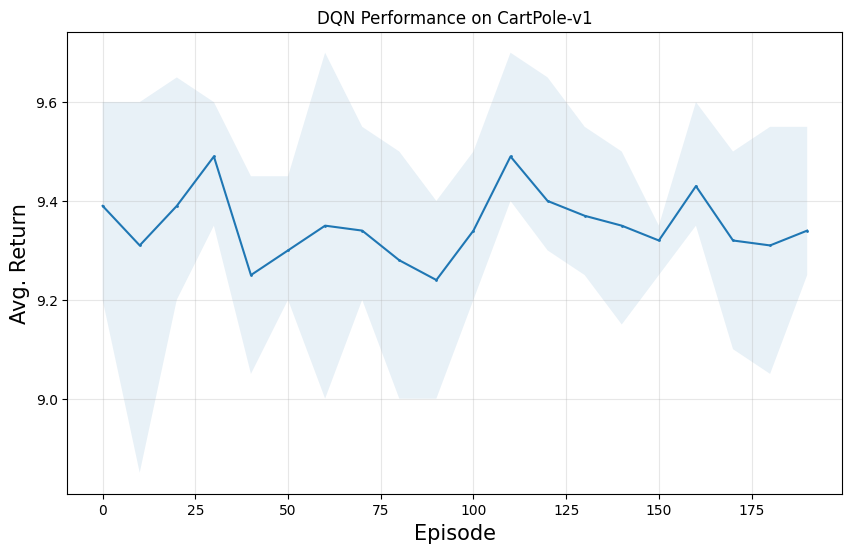

In [7]:
# Note: Feels free for adjust andy hyper paramter you want for trainin. Except these: seed, env_name, state_space_size
if __name__ == "__main__":
    env_name = 'CartPole-v1' # 'myenv'#
    num_episodes_train = 200
    num_episodes_test = 20
    learning_rate = 5e-4 
    
    env = gym.make(env_name)
    action_space_size = env.action_space.n
    state_space_size = 4
    
    num_seeds = 5
    l = num_episodes_train // 10
    res = np.zeros((num_seeds, l))
    gamma = 0.99
    
    for i in tqdm.tqdm(range(num_seeds)):
        reward_means = []
        agent = DQNAgent(env_name, lr=learning_rate, gamma=gamma)
        
        for m in range(num_episodes_train):
            episode_reward, episode_loss, steps = agent.train()
            
            if m % 10 == 0:
                print(f"Episode: {m}")
                
                G = np.zeros(num_episodes_test)
                for k in range(num_episodes_test):
                    g = agent.test()
                    G[k] = g
                
                reward_mean = G.mean()
                reward_sd = G.std()
                print(f"The test reward for episode {m} is {reward_mean} with a standard deviation of {reward_sd}.")
                reward_means.append(reward_mean)
        
        res[i] = np.array(reward_means)
    
    ks = np.arange(l) * 10
    avs = np.mean(res, axis=0)
    maxs = np.max(res, axis=0)
    mins = np.min(res, axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(ks, mins, maxs, alpha=0.1)
    plt.plot(ks, avs, '-o', markersize=1)
    
    plt.xlabel('Episode', fontsize=15)
    plt.ylabel('Avg. Return', fontsize=15)
    plt.title('DQN Performance on CartPole-v1')
    plt.grid(True, alpha=0.3)
    plt.savefig('dqn_performance.png')
    plt.show()

## Answer these questions:

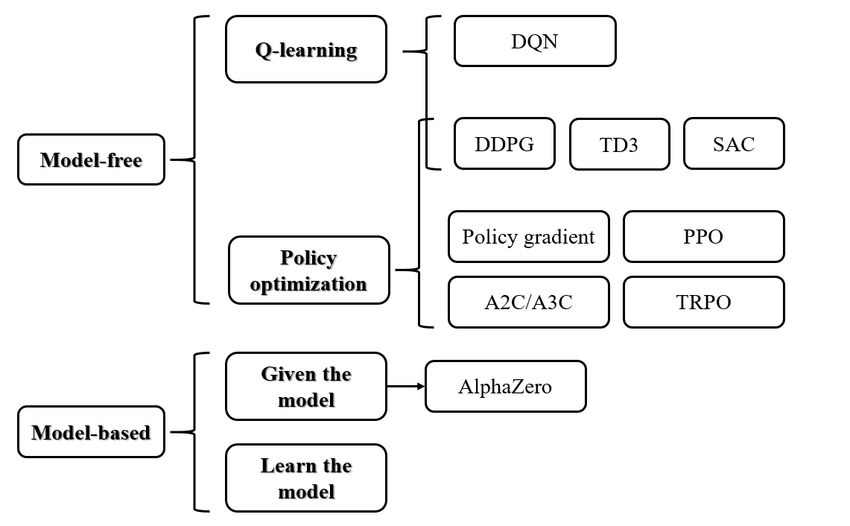

#### Q1)  According given image, explain the value based, policy based apporches in MODEL FREE.
$\\$
##### `Answer`:
- Value-based Methods:

    Learn a value function (Q-value or V-value) to estimate expected returns

    Select actions by choosing the one with maximum value (e.g., ε-greedy)

    Examples: Q-Learning, DQN

    Advantages: More sample-efficient, stable learning

    Disadvantages: Limited to discrete action spaces

- Policy-based Methods:

    Directly learn the policy (action probabilities)

    No value function required (though some use both = Actor-Critic)
    
    Examples: REINFORCE, PPO

    Advantages: Handles continuous action spaces, stochastic policies

    Disadvantages: High variance, less sample-efficient

    Key difference: Value-based methods learn "what is good" (values), while policy-based methods learn "what to do" (actions).

#### Q2) The DQN you implemented is consider which one of those? why? what is rule of the Policy Class you implemented?
$\\$
##### `Answer`:
- DQN is Value-based because: It learns a Q-function (through QNetwork)
    and Uses max Q-value for action selection (via policy.select_action())
    and  Implements Q-learning updates (Bellman equation)

- Policy Class Role: it Implements ε-greedy exploration (not a learned policy)
    and Decays ε over time (controlled by epsilon_decay)
    and Converts Q-values to actions (select_action() calls argmax on Q-values).
    This is a behavior policy, not the learned policy (which is implicit in Q-values).

#### Q3) Explain the rule of Replay Buffer in algorithm. (why we should use this?)
$\\$
##### `Answer`:
- The replay buffer:

    Stores transitions: (state, action, reward, next_state)

    Breaks temporal correlations: Random sampling prevents biased updates from sequential experiences

    Improves sample efficiency: Reuses past experiences

    Stabilizes learning: Smoothes training by averaging over many experiences

- Key benefits in your implementation:

    burn_in_memory() pre-fills buffer with random exploration

    sample_batch() provides uncorrelated training samples

    Enables off-policy learning (updates can use old experiences)

#### Q4) Explain the rule of epsilon
$\\$
##### `Answer`:
- Controls exploration-exploitation tradeoff:

    High $\epsilon\rightarrow$ More random actions (exploration)
    Low $\epsilon\rightarrow$ More Q-max actions (exploitation)

- In our implementation:

    Starts at `epsilon_start=1.0` (100% random)

    Decays to `epsilon_end=0.05` (5% random)

    Decay rate: `epsilon_decay=0.995` per episode

- Why it matters:

    Early high $\epsilon$: Discovers diverse states

    Later low $\epsilon$: Refines policy based on learned Q-values

    Prevents premature convergence to suboptimal policies

# Section Two

Section Two challenges you to implement the Soft Actor-Critic (SAC) algorithm, representing a significant shift from the value-based approach of DQN to a state-of-the-art actor-critic method. SAC belongs to the family of maximum entropy reinforcement learning algorithms, which explicitly balance reward maximization with maintaining stochastic policies for better exploration. Unlike DQN’s discrete action selection, SAC can naturally handle continuous action spaces while incorporating entropy regularization to encourage exploration and prevent premature convergence to suboptimal policies. You’ll need to architect multiple neural networks - an actor network that outputs actions, critic networks that evaluate state-action pairs, and potentially a value network depending on your implementation choice.

Implementing SAC requires understanding several advanced concepts including the reparameterization trick for gradient computation through stochastic nodes, soft value functions that incorporate entropy bonuses, and the careful orchestration of multiple function approximators. The algorithm’s elegance lies in its ability to automatically tune the temperature parameter that balances exploration and exploitation. As you build your implementation, consider how SAC differs fundamentally from DQN in its approach to the exploration-exploitation trade-off and its ability to maintain a stochastic policy throughout training. The comparison questions at the end will help you articulate these differences and understand when each algorithm might be preferred. Your implementation will again be tested on CartPole-v1, allowing direct comparison with your DQN results and highlighting the distinct characteristics of policy-based versus value-based methods.

### Implement SAC

Implement SAC with (Cart-pole) enviroment.

Episode 10, Average Score: 29.4
Episode 20, Average Score: 21.1
Episode 30, Average Score: 21.7
Episode 40, Average Score: 14.5
Episode 50, Average Score: 20.8
Episode 60, Average Score: 19.3
Episode 70, Average Score: 20.9
Episode 80, Average Score: 20.3
Episode 90, Average Score: 18.9
Episode 100, Average Score: 16.6
Episode 110, Average Score: 12.9
Episode 120, Average Score: 11.1
Episode 130, Average Score: 10.5
Episode 140, Average Score: 10.4
Episode 150, Average Score: 9.5
Episode 160, Average Score: 10.8
Episode 170, Average Score: 10.2
Episode 180, Average Score: 10.8
Episode 190, Average Score: 10.2
Episode 200, Average Score: 10.9
Episode 210, Average Score: 15.6
Episode 220, Average Score: 10.3
Episode 230, Average Score: 15.7
Episode 240, Average Score: 17.6
Episode 250, Average Score: 15.9
Episode 260, Average Score: 16.3
Episode 270, Average Score: 12.4
Episode 280, Average Score: 11.5
Episode 290, Average Score: 13.3
Episode 300, Average Score: 11.6


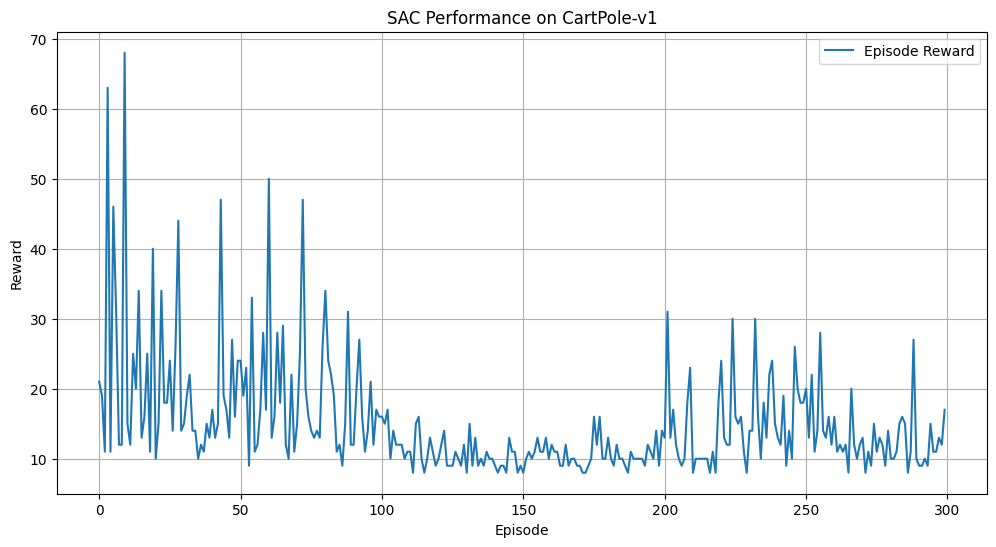

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gymnasium as gym
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt

# Hyperparameters
GAMMA = 0.99
TAU = 0.005
ALPHA = 0.2
LR = 3e-4
HIDDEN_SIZE = 256
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 256
TARGET_UPDATE_INTERVAL = 1
AUTOMATIC_ENTROPY_TUNING = True
NUM_EPISODES = 300
SEED = 42

# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Transition tuple
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*transitions))
        
        states = torch.FloatTensor(np.array(batch.state))
        actions = torch.LongTensor(np.array(batch.action)).unsqueeze(1)  # Keep as LongTensor
        rewards = torch.FloatTensor(np.array(batch.reward)).unsqueeze(1)
        next_states = torch.FloatTensor(np.array(batch.next_state))
        dones = torch.FloatTensor(np.array(batch.done)).unsqueeze(1)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

# Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size=HIDDEN_SIZE):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.softmax(x, dim=-1)
    
    def sample(self, state):
        probs = self.forward(state)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return action, log_prob, entropy

# Q Network
class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size=HIDDEN_SIZE):
        super(QNetwork, self).__init__()
        
        # Q1 architecture
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        # Q2 architecture
        self.linear4 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear6 = nn.Linear(hidden_size, 1)
        
    def forward(self, state, action):
        # Action should be one-hot encoded
        xu = torch.cat([state, action], dim=1)
        
        x1 = F.relu(self.linear1(xu))
        x1 = F.relu(self.linear2(x1))
        x1 = self.linear3(x1)
        
        x2 = F.relu(self.linear4(xu))
        x2 = F.relu(self.linear5(x2))
        x2 = self.linear6(x2)
        
        return x1, x2

# Value Network
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_size=HIDDEN_SIZE):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

# SAC Agent
class SACAgent:
    def __init__(self, env):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        
        # Networks
        self.policy = PolicyNetwork(self.state_dim, self.action_dim)
        self.q_network = QNetwork(self.state_dim, self.action_dim)
        self.q_target = QNetwork(self.state_dim, self.action_dim)
        self.value_network = ValueNetwork(self.state_dim)
        self.value_target = ValueNetwork(self.state_dim)
        
        # Copy parameters to target networks
        self.q_target.load_state_dict(self.q_network.state_dict())
        self.value_target.load_state_dict(self.value_network.state_dict())
        
        # Optimizers
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=LR)
        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=LR)
        self.value_optimizer = optim.Adam(self.value_network.parameters(), lr=LR)
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE)
        
        # Automatic entropy tuning
        self.automatic_entropy_tuning = AUTOMATIC_ENTROPY_TUNING
        if self.automatic_entropy_tuning:
            self.target_entropy = -torch.log(torch.tensor(1.0 / self.action_dim)) * 0.98  # Adjusted for discrete actions
            self.log_alpha = torch.zeros(1, requires_grad=True)
            self.alpha_optimizer = optim.Adam([self.log_alpha], lr=LR)
            self.alpha = self.log_alpha.exp()
        else:
            self.alpha = ALPHA
        
        self.total_steps = 0
    
    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0)
        if not evaluate:
            action, _, _ = self.policy.sample(state)
            return action.item()
        else:
            probs = self.policy(state)
            action = torch.argmax(probs).item()
            return action
    
    def update_parameters(self, batch):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = batch
        
        # Keep action_batch as LongTensor and one-hot encode it
        action_batch_onehot = F.one_hot(action_batch.squeeze(), num_classes=self.action_dim).float()
        
        with torch.no_grad():
            # Sample actions from policy for next states
            next_action, next_log_prob, _ = self.policy.sample(next_state_batch)
            next_action_onehot = F.one_hot(next_action, num_classes=self.action_dim).float()
            
            # Compute target Q values
            q1_next, q2_next = self.q_target(next_state_batch, next_action_onehot)
            q_next = torch.min(q1_next, q2_next)
            value_next = q_next - self.alpha * next_log_prob.unsqueeze(1)
            
            # Compute target value
            target_value = reward_batch + (1 - done_batch) * GAMMA * value_next
        
        # Update value network
        current_value = self.value_network(state_batch)
        value_loss = F.mse_loss(current_value, target_value)
        
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        # Update Q networks
        current_q1, current_q2 = self.q_network(state_batch, action_batch_onehot)
        q_loss = F.mse_loss(current_q1, target_value) + F.mse_loss(current_q2, target_value)
        
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()
        
        # Update policy
        actions, log_prob, entropy = self.policy.sample(state_batch)
        actions_onehot = F.one_hot(actions, num_classes=self.action_dim).float()
        q1, q2 = self.q_network(state_batch, actions_onehot)
        q = torch.min(q1, q2)
        
        policy_loss = (self.alpha * log_prob.unsqueeze(1) - q).mean()
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        # Update alpha if automatic tuning is enabled
        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_prob + self.target_entropy).detach()).mean()
            
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
            
            self.alpha = self.log_alpha.exp()
        
        # Update target networks
        if self.total_steps % TARGET_UPDATE_INTERVAL == 0:
            for target_param, param in zip(self.value_target.parameters(), self.value_network.parameters()):
                target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
            
            for target_param, param in zip(self.q_target.parameters(), self.q_network.parameters()):
                target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
        
        self.total_steps += 1
        
        return value_loss.item(), q_loss.item(), policy_loss.item(), entropy.mean().item()
    
    def train(self, num_episodes):
        scores = []
        
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                
                self.replay_buffer.push(state, action, reward, next_state, done)
                episode_reward += reward
                state = next_state
                
                if len(self.replay_buffer) > BATCH_SIZE:
                    batch = self.replay_buffer.sample(BATCH_SIZE)
                    self.update_parameters(batch)
            
            scores.append(episode_reward)
            
            if (episode + 1) % 10 == 0:
                avg_score = np.mean(scores[-10:])
                print(f"Episode {episode + 1}, Average Score: {avg_score:.1f}")
        
        return scores

# Training
env = gym.make('CartPole-v1')
agent = SACAgent(env)
scores = agent.train(NUM_EPISODES)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(scores, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('SAC Performance on CartPole-v1')
plt.legend()
plt.grid(True)
plt.show()

env.close()

Run 1/5
Episode 10, Average Score: 15.8
Episode 20, Average Score: 31.0
Episode 30, Average Score: 24.8
Episode 40, Average Score: 24.7
Episode 50, Average Score: 22.5
Episode 60, Average Score: 16.6
Episode 70, Average Score: 24.3
Episode 80, Average Score: 12.6
Episode 90, Average Score: 11.6
Episode 100, Average Score: 11.4
Episode 110, Average Score: 10.5
Episode 120, Average Score: 10.4
Episode 130, Average Score: 10.6
Episode 140, Average Score: 10.2
Episode 150, Average Score: 9.9
Episode 160, Average Score: 9.7
Episode 170, Average Score: 10.1
Episode 180, Average Score: 9.6
Episode 190, Average Score: 10.1
Episode 200, Average Score: 9.8
Episode 210, Average Score: 9.4
Episode 220, Average Score: 10.2
Episode 230, Average Score: 9.5
Episode 240, Average Score: 9.7
Episode 250, Average Score: 9.5
Episode 260, Average Score: 9.3
Episode 270, Average Score: 9.1
Episode 280, Average Score: 9.4
Episode 290, Average Score: 9.6
Episode 300, Average Score: 9.7
Run 2/5
Episode 10, Aver

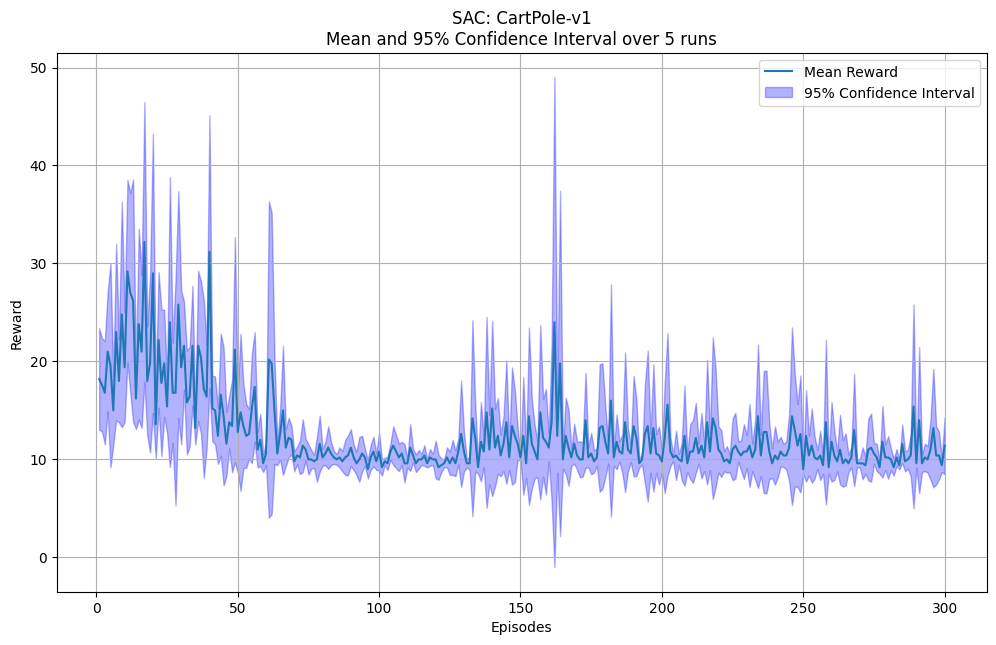

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import gymnasium as gym

# Hyperparameters
GAMMA = 0.99
TAU = 0.005
ALPHA = 0.2
LR = 3e-4
HIDDEN_SIZE = 256
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 256
TARGET_UPDATE_INTERVAL = 1
AUTOMATIC_ENTROPY_TUNING = True
N_EPISODES = 300
N_RUNS = 5

# Transition tuple
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

# Set random seed for reproducibility
def set_seed(seed, env=None):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if env is not None:
        env.reset(seed=seed)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*transitions))
        
        states = torch.FloatTensor(np.array(batch.state))
        actions = torch.LongTensor(np.array(batch.action)).unsqueeze(1)
        rewards = torch.FloatTensor(np.array(batch.reward)).unsqueeze(1)
        next_states = torch.FloatTensor(np.array(batch.next_state))
        dones = torch.FloatTensor(np.array(batch.done)).unsqueeze(1)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

# Policy Network
class Policy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size=HIDDEN_SIZE):
        super(Policy, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.softmax(x, dim=-1)
    
    def sample(self, state):
        probs = self.forward(state)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return action, log_prob, entropy

# Q Network
class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size=HIDDEN_SIZE):
        super(QNetwork, self).__init__()
        # Q1 architecture
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        # Q2 architecture
        self.linear4 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear6 = nn.Linear(hidden_size, 1)
        
    def forward(self, state, action):
        xu = torch.cat([state, action], dim=1)
        x1 = F.relu(self.linear1(xu))
        x1 = F.relu(self.linear2(x1))
        x1 = self.linear3(x1)
        x2 = F.relu(self.linear4(xu))
        x2 = F.relu(self.linear5(x2))
        x2 = self.linear6(x2)
        return x1, x2

# Value Network
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_size=HIDDEN_SIZE):
        super(ValueNetwork, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

# SAC Agent
class SACAgent:
    def __init__(self, env, lr=LR):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        
        # Networks
        self.policy = Policy(self.state_dim, self.action_dim)
        self.q_network = QNetwork(self.state_dim, self.action_dim)
        self.q_target = QNetwork(self.state_dim, self.action_dim)
        self.value_network = ValueNetwork(self.state_dim)
        self.value_target = ValueNetwork(self.state_dim)
        
        # Copy parameters to target networks
        self.q_target.load_state_dict(self.q_network.state_dict())
        self.value_target.load_state_dict(self.value_network.state_dict())
        
        # Optimizers
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_network.parameters(), lr=lr)
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE)
        
        # Automatic entropy tuning
        self.automatic_entropy_tuning = AUTOMATIC_ENTROPY_TUNING
        if self.automatic_entropy_tuning:
            self.target_entropy = -torch.log(torch.tensor(1.0 / self.action_dim)) * 0.98
            self.log_alpha = torch.zeros(1, requires_grad=True)
            self.alpha_optimizer = optim.Adam([self.log_alpha], lr=lr)
            self.alpha = self.log_alpha.exp()
        else:
            self.alpha = ALPHA
        
        self.total_steps = 0
    
    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0)
        if not evaluate:
            action, _, _ = self.policy.sample(state)
            return action.item()
        else:
            probs = self.policy(state)
            action = torch.argmax(probs).item()
            return action
    
    def update_parameters(self, batch):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = batch
        action_batch_onehot = F.one_hot(action_batch.squeeze(), num_classes=self.action_dim).float()
        
        with torch.no_grad():
            next_action, next_log_prob, _ = self.policy.sample(next_state_batch)
            next_action_onehot = F.one_hot(next_action, num_classes=self.action_dim).float()
            q1_next, q2_next = self.q_target(next_state_batch, next_action_onehot)
            q_next = torch.min(q1_next, q2_next)
            value_next = q_next - self.alpha * next_log_prob.unsqueeze(1)
            target_value = reward_batch + (1 - done_batch) * GAMMA * value_next
        
        # Update value network
        current_value = self.value_network(state_batch)
        value_loss = F.mse_loss(current_value, target_value)
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        # Update Q networks
        current_q1, current_q2 = self.q_network(state_batch, action_batch_onehot)
        q_loss = F.mse_loss(current_q1, target_value) + F.mse_loss(current_q2, target_value)
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()
        
        # Update policy
        actions, log_prob, entropy = self.policy.sample(state_batch)
        actions_onehot = F.one_hot(actions, num_classes=self.action_dim).float()
        q1, q2 = self.q_network(state_batch, actions_onehot)
        q = torch.min(q1, q2)
        policy_loss = (self.alpha * log_prob.unsqueeze(1) - q).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        # Update alpha
        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_prob + self.target_entropy).detach()).mean()
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
            self.alpha = self.log_alpha.exp()
        
        # Update target networks
        if self.total_steps % TARGET_UPDATE_INTERVAL == 0:
            for target_param, param in zip(self.value_target.parameters(), self.value_network.parameters()):
                target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
            for target_param, param in zip(self.q_target.parameters(), self.q_network.parameters()):
                target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
        
        self.total_steps += 1
        return value_loss.item(), q_loss.item(), policy_loss.item(), entropy.mean().item()
    
    def train(self, n_episodes):
        scores = []
        for episode in range(n_episodes):
            state, _ = self.env.reset()
            episode_reward = 0
            done = False
            while not done:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.replay_buffer.push(state, action, reward, next_state, done)
                episode_reward += reward
                state = next_state
                if len(self.replay_buffer) > BATCH_SIZE:
                    batch = self.replay_buffer.sample(BATCH_SIZE)
                    self.update_parameters(batch)
            scores.append(episode_reward)
            if (episode + 1) % 10 == 0:
                avg_score = np.mean(scores[-10:])
                print(f"Episode {episode + 1}, Average Score: {avg_score:.1f}")
        return scores

# Main training loop
all_scores = []
for run in range(N_RUNS):
    print(f"Run {run+1}/{N_RUNS}")
    seed = 100 + run
    env = gym.make('CartPole-v1')
    set_seed(seed, env)
    agent = SACAgent(env, lr=LR)
    scores = agent.train(n_episodes=N_EPISODES)
    all_scores.append(scores)
    env.close()

# Plotting
all_scores = np.array(all_scores)
mean_scores = np.mean(all_scores, axis=0)
std_scores = np.std(all_scores, axis=0)
conf_interval = 1.96 * std_scores / np.sqrt(N_RUNS)

episodes = np.arange(1, N_EPISODES + 1)

plt.figure(figsize=(12, 7))
plt.plot(episodes, mean_scores, label='Mean Reward')
plt.fill_between(episodes, mean_scores - conf_interval, mean_scores + conf_interval, 
                 alpha=0.3, color='blue', label='95% Confidence Interval')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('SAC: CartPole-v1\nMean and 95% Confidence Interval over 5 runs')
plt.legend()
plt.grid(True)
plt.show()

# Q1) Plot the average return with 5 different seed, mean and std.

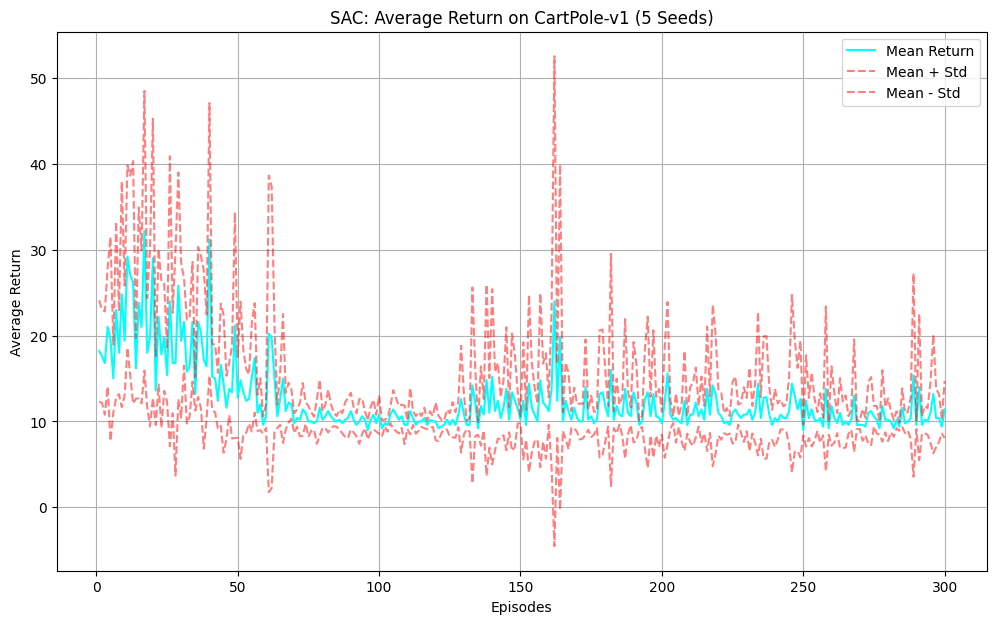

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_scores is available from the SAC training loop
# all_scores: shape (N_RUNS, N_EPISODES) = (5, 300)
mean_scores = np.mean(all_scores, axis=0)  # Mean return across 5 runs
std_scores = np.std(all_scores, axis=0)   # Standard deviation across 5 runs
episodes = np.arange(1, N_EPISODES + 1)   # Episode numbers (1 to 300)

# Plotting with Matplotlib
plt.figure(figsize=(12, 7))
plt.plot(episodes, mean_scores, label='Mean Return', color='cyan')
plt.plot(episodes, mean_scores + std_scores, label='Mean + Std', color='red', linestyle='--', alpha=0.5)
plt.plot(episodes, mean_scores - std_scores, label='Mean - Std', color='red', linestyle='--', alpha=0.5)
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.title('SAC: Average Return on CartPole-v1 (5 Seeds)')
plt.legend()
plt.grid(True)
plt.show()

# Q2: Explain the SAC Algorithm and Differences from DQN

## SAC Algorithm Explanation
Soft Actor-Critic (SAC) is an off-policy, actor-critic reinforcement learning algorithm that maximizes both expected cumulative reward and policy entropy for robust exploration. In CartPole-v1, SAC is adapted for discrete actions (left, right) and includes:

- **Stochastic Policy (Actor)**: Outputs probabilities over actions via a softmax, sampling actions using a `Categorical` distribution. It maximizes reward plus an entropy term, weighted by a temperature parameter ($\alpha$).
- **Soft Q-Functions (Critic)**: Two Q-networks estimate state-action values, taking state and one-hot encoded actions as input. They use double Q-learning to reduce overestimation bias.
- **Soft Value Function**: A value network estimates $V(s) = \mathbb{E}_{a \sim \pi}[Q(s, a) - \alpha \log \pi(a|s)] $ , incorporating entropy.
- **Entropy Regularization**: Adds $\alpha H(\pi)$ to the objective, where $ H(\pi) $ is policy entropy, encouraging exploration. $\alpha$ is automatically tuned to a target entropy.
- **Replay Buffer**: Stores transitions $(s, a, r, s', d)$ for off-policy learning.
- **Target Networks**: Uses target Q and value networks, updated softly with $\tau = 0.005$, for stability.
- **Updates**:
  - Value network: Minimizes MSE to $ r + \gamma (Q(s', a') - \alpha \log \pi(a'|s')) $.
  - Q-networks: Minimize MSE to $ r + \gamma V(s') $.
  - Policy: Maximizes $ Q(s, a) - \alpha \log \pi(a|s) $.
  - $\alpha$: Adjusted to match target entropy (e.g., $- \log(1/2) \times 0.98$ for CartPole).

In CartPole, SAC learns to balance the pole, earning +1 per time step (max 200), with a stochastic policy ensuring exploration.

## Differences Between SAC and DQN
| **Aspect** | **SAC** | **DQN** |
|------------|---------|---------|
| **Type** | Actor-Critic: learns policy and value functions. | Value-based: learns Q-values only. |
| **Policy** | Stochastic, outputs probabilities (softmax in CartPole). | Deterministic, selects $\arg\max_a Q(s, a)$. |
| **Exploration** | Entropy regularization with tunable $\alpha$. | Epsilon-greedy with decaying $\epsilon. |
| **Action Space** | Adapted for discrete actions (CartPole); native for continuous. | Designed for discrete actions. |
| **Networks** | Policy, two Q-networks, value network, and targets. | One Q-network and target. |
| **Objective** | Maximizes reward + entropy: $ J = \mathbb{E}[\sum r_t + \alpha H(\pi)] $. | Maximizes reward: $ J = \mathbb{E}[\sum r_t] $. |
| **Q-Update** | Soft Q: $ Q = r + \gamma \mathbb{E}[V(s')] $. | Standard Q: $ Q = r + \gamma \max_{a'} Q(s', a') $. |
| **Stability** | Double Q-learning, soft updates, entropy improve stability. | Target network reduces overestimation; simpler but less robust. |
| **Complexity** | More complex (multiple networks, entropy tuning). | Simpler (single network, less tuning). |
| **CartPole Performance** | Slower initial learning but robust due to entropy. | Faster convergence but may lack exploration. |

**When to Use**:
- **SAC**: For robust exploration, continuous actions, or complex environments.
- **DQN**: For simple discrete-action tasks like CartPole with faster convergence.

# Q3: Categorization of SAC According to the Diagram

Based on the context of the previous questions and the SAC implementation for CartPole-v1, the Soft Actor-Critic (SAC) algorithm is categorized as follows:

- **Reinforcement Learning Paradigm**: SAC is an **actor-critic** algorithm, combining a policy-based method (actor) with value-based methods (critic).
- **Policy Type**: It uses a **stochastic policy**, outputting a probability distribution over actions (in CartPole-v1, a softmax over discrete actions).
- **Learning Approach**: SAC is **off-policy**, as it uses a replay buffer to learn from past experiences, allowing it to reuse transitions independently of the current policy.
- **Entropy Framework**: SAC belongs to the **maximum entropy reinforcement learning** family, as it maximizes both expected reward and policy entropy, promoting exploration via an entropy term weighted by a temperature parameter \(\alpha\).
- **Action Space**: While SAC is typically designed for **continuous action spaces** (using a normal distribution), in the CartPole-v1 implementation, it is adapted for **discrete action spaces** using a `Categorical` distribution.

Thus, SAC is categorized as an **off-policy, actor-critic, maximum entropy reinforcement learning algorithm**, adapted for discrete actions in this specific implementation.

# Q4: Components of SAC and Their Functionality

The Soft Actor-Critic (SAC) algorithm, as implemented for CartPole-v1, consists of several key components that work together to optimize a stochastic policy while maximizing both expected reward and policy entropy. Below, each component is explained along with its functionality, tailored to the discrete action space context of CartPole-v1.

## 1. Stochastic Policy (Actor)
- **Description**: The policy network is a neural network that maps states to a probability distribution over discrete actions (left or right in CartPole-v1). It outputs probabilities via a softmax function and samples actions using a `Categorical` distribution.
- **Functionality**:
  - **Action Selection**: During training, actions are sampled stochastically from the policy distribution ($\pi(a|s)$) to encourage exploration. For evaluation, the action with the highest probability is selected ($\arg\max_a \pi(a|s)$).
  - **Objective**: The policy is optimized to maximize the expected soft Q-value minus an entropy penalty: $ J(\pi) = \mathbb{E}_{a \sim \pi} [Q(s, a) - \alpha \log \pi(a|s)] $, balancing reward and exploration.
  - **Implementation**: A 3-layer MLP (input: state dimension 4, hidden: 256, output: 2 actions) with softmax activation. The `sample` method returns the action, log probability, and entropy.

## 2. Soft Q-Functions (Critic)
- **Description**: Two Q-networks (\(Q_{\theta_1}, Q_{\theta_2}\)) estimate the soft Q-value for state-action pairs, taking the state and a one-hot encoded action as input (due to CartPole’s discrete actions).
- **Functionality**:
  - **Q-Value Estimation**: Each Q-network outputs a scalar representing the expected future reward plus entropy bonuses: $ Q(s, a) = r + \gamma \mathbb{E}[V(s')] $.
  - **Double Q-Learning**: The minimum of the two Q-values ($\min(Q_1, Q_2)$) is used to reduce overestimation bias, a technique inspired by Double DQN.
  - **Training**: Updated to minimize the mean squared error between predicted Q-values and the target $ r + \gamma V(s') $, where $ V(s') $ is from the target value network.
  - **Implementation**: Two 3-layer MLPs (input: state dim + action dim, hidden: 256, output: 1) for Q1 and Q2, with actions one-hot encoded (2D for CartPole).

## 3. Soft Value Function
- **Description**: The value network estimates the soft state value $ V(s) $, which represents the expected future reward plus entropy under the current policy.
- **Functionality**:
  - **Value Estimation**: Computes $ V(s) = \mathbb{E}_{a \sim \pi} [Q(s, a) - \alpha \log \pi(a|s)] $, incorporating the entropy of the policy.
  - **Target for Q-Networks**: Provides the next-state value for Q-network updates, stabilizing training by smoothing the target.
  - **Training**: Minimizes the mean squared error between predicted $ V(s) $ and the target $ r + \gamma (Q(s', a') - \alpha \log \pi(a'|s')) $, where $ a' $ is sampled from the policy.
  - **Implementation**: A 3-layer MLP (input: state dim 4, hidden: 256, output: 1).

## 4. Replay Buffer
- **Description**: A storage mechanism for transitions $(s, a, r, s', d)$, where $ s $ is the state, $ a $ is the action (integer in CartPole), $ r $ is the reward (+1 per step), $s'$ is the next state, and $ d $ is the done flag.
- **Functionality**:
  - **Experience Storage**: Stores transitions in a `deque` with a capacity (e.g., 1M) for off-policy learning.
  - **Sampling**: Randomly samples batches (size 256) for network updates, enabling efficient learning from past experiences.
  - **Implementation**: Uses `namedtuple` for transitions and returns tensors (states, next states, rewards, dones as `FloatTensor`; actions as `LongTensor`).

## 5. Target Networks
- **Description**: SAC includes target Q-networks ($Q_{\theta_1'}, Q_{\theta_2'} $) and a target value network ($ V_{\psi'} $), which are copies of the main Q and value networks.
- **Functionality**:
  - **Stabilization**: Provide stable targets for Q and value network updates, reducing training instability caused by rapidly changing networks.
  - **Soft Updates**: Updated via a polyak averaging rule: $\theta' \gets \tau \theta + (1 - \tau) \theta' $, where $\tau = 0.005$, ensuring gradual changes.
  - **Implementation**: Initialized with the same weights as main networks and updated every step (or per `TARGET_UPDATE_INTERVAL`).

## 6. Entropy Regularization and Temperature ($\alpha$)
- **Description**: The entropy term $ H(\pi) = -\sum_a \pi(a|s) \log \pi(a|s)$ is added to the policy objective, weighted by a temperature parameter $\alpha$.
- **Functionality**:
  - **Exploration**: Encourages the policy to maintain high entropy (diverse action probabilities), preventing premature convergence to suboptimal actions.
  - **Automatic Tuning**: $\alpha$ is learned to match a target entropy (e.g., $- \log(1/2) \times 0.98$ for CartPole’s 2 actions), balancing exploration and exploitation.
  - **Implementation**: A learnable `log_alpha` parameter is optimized using Adam to minimize $ - \alpha (\log \pi(a|s) + H_{\text{target}}) $, and $\alpha = \exp(\log \alpha)$.

## 7. Optimizers
- **Description**: Adam optimizers are used for the policy, Q-networks, value network, and $\alpha$ (if tuned automatically).
- **Functionality**:
  - **Gradient Descent**: Update network parameters by minimizing respective loss functions (policy loss, Q-loss, value loss, alpha loss).
  - **Learning Rate**: A small learning rate (e.g., $3 \times 10^{-4}$) ensures stable updates.
  - **Implementation**: Separate Adam optimizers for each component, with gradients computed via backpropagation.

## Summary
In the CartPole-v1 SAC implementation, these components work together to learn a stochastic policy that balances the pole (maximizing reward) while maintaining exploration via entropy. The policy samples actions, Q-networks estimate action values, the value network stabilizes targets, the replay buffer enables off-policy learning, target networks improve stability, and entropy tuning ensures robust exploration. This contrasts with simpler RL algorithms by integrating both reward maximization and policy entropy.